In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cpu')



In [2]:

def inverse_warping(img, left_cam, right_cam, depth):
    # img: [batch_size, height, width, channels]

    # cameras (K, R, t)
    # print('left_cam: {}'.format(left_cam.shape))
    R_left = left_cam[:, 0:1, 0:3, 0:3]  # [B, 1, 3, 3]
    R_right = right_cam[:, 0:1, 0:3, 0:3]  # [B, 1, 3, 3]
    t_left = left_cam[:, 0:1, 0:3, 3:4]  # [B, 1, 3, 1]
    t_right = right_cam[:, 0:1, 0:3, 3:4]  # [B, 1, 3, 1]
    K_left = left_cam[:, 1:2, 0:3, 0:3]  # [B, 1, 3, 3]
    K_right = right_cam[:, 1:2, 0:3, 0:3]  # [B, 1, 3, 3]

    K_left = K_left.squeeze(1)  # [B, 3, 3]
    # print('left_cam: {}'.format(left_cam))
    # print('K_left: {}'.format(K_left))

    try:
        K_left_inv = torch.inverse(K_left)  # [B, 3, 3]
    except Exception as e:
        # print('K_left: {}'.format(K_left.cpu().numpy()))
        print(e)
        exit(-1)

    R_left_trans = R_left.squeeze(1).permute(0, 2, 1)  # [B, 3, 3]
    R_right_trans = R_right.squeeze(1).permute(0, 2, 1)  # [B, 3, 3]

    R_left = R_left.squeeze(1)
    t_left = t_left.squeeze(1)
    R_right = R_right.squeeze(1)
    t_right = t_right.squeeze(1)

    ## estimate egomotion by inverse composing R1,R2 and t1,t2
    R_rel = torch.matmul(R_right, R_left_trans)  # [B, 3, 3]
    t_rel = t_right - torch.matmul(R_rel, t_left)  # [B, 3, 1]
    ## now convert R and t to transform mat, as in SFMlearner
    batch_size = R_left.shape[0]
    filler = torch.Tensor([0.0, 0.0, 0.0, 1.0]).to(device).reshape(1, 1, 4)  # [1, 1, 4]
    filler = filler.repeat(batch_size, 1, 1)  # [B, 1, 4]
    transform_mat = torch.cat([R_rel, t_rel], dim=2)  # [B, 3, 4]
    transform_mat = torch.cat([transform_mat.float(), filler.float()], dim=1)  # [B, 4, 4]

    batch_size, img_height, img_width, _ = img.shape
    # print('depth: {}'.format(depth.shape))
    depth = depth.reshape(batch_size, 1, img_height * img_width)  # [batch_size, 1, height * width]

    grid = _meshgrid_abs(img_height, img_width)  # [3, height * width]
    grid = grid.unsqueeze(0).repeat(batch_size, 1, 1)  # [batch_size, 3, height * width]
    cam_coords = _pixel2cam(depth, grid, K_left_inv)  # [batch_size, 3, height * width]
    ones = torch.ones([batch_size, 1, img_height * img_width], device=device)  # [batch_size, 1, height * width]
    cam_coords_hom = torch.cat([cam_coords, ones], dim=1)  # [batch_size, 4, height * width]

    # Get projection matrix for target camera frame to source pixel frame
    hom_filler = torch.Tensor([0.0, 0.0, 0.0, 1.0]).to(device).reshape(1, 1, 4)  # [1, 1, 4]
    hom_filler = hom_filler.repeat(batch_size, 1, 1)  # [B, 1, 4]
    intrinsic_mat_hom = torch.cat([K_left.float(), torch.zeros([batch_size, 3, 1], device=device)], dim=2)  # [B, 3, 4]
    intrinsic_mat_hom = torch.cat([intrinsic_mat_hom, hom_filler], dim=1)  # [B, 4, 4]
    proj_target_cam_to_source_pixel = torch.matmul(intrinsic_mat_hom, transform_mat)  # [B, 4, 4]
    source_pixel_coords = _cam2pixel(cam_coords_hom, proj_target_cam_to_source_pixel)  # [batch_size, 2, height * width]
    source_pixel_coords = source_pixel_coords.reshape(batch_size, 2, img_height, img_width)   # [batch_size, 2, height, width]
    source_pixel_coords = source_pixel_coords.permute(0, 2, 3, 1)  # [batch_size, height, width, 2]
    warped_right, mask = _spatial_transformer(img, source_pixel_coords)
    return warped_right, mask


def _meshgrid_abs(height, width):
    """Meshgrid in the absolute coordinates."""
    x_t = torch.matmul(
        torch.ones([height, 1]),
        torch.linspace(-1.0, 1.0, width).unsqueeze(1).permute(1, 0)
    )  # [height, width]
    y_t = torch.matmul(
        torch.linspace(-1.0, 1.0, height).unsqueeze(1),
        torch.ones([1, width])
    )
    x_t = (x_t + 1.0) * 0.5 * (width - 1)
    y_t = (y_t + 1.0) * 0.5 * (height - 1)
    x_t_flat = x_t.reshape(1, -1)
    y_t_flat = y_t.reshape(1, -1)
    ones = torch.ones_like(x_t_flat)
    grid = torch.cat([x_t_flat, y_t_flat, ones], dim=0)  # [3, height * width]
    return grid.to(device)


def _pixel2cam(depth, pixel_coords, intrinsic_mat_inv):
    """Transform coordinates in the pixel frame to the camera frame."""
    cam_coords = torch.matmul(intrinsic_mat_inv.float(), pixel_coords.float()) * depth.float()
    return cam_coords


def _cam2pixel(cam_coords, proj_c2p):
    """Transform coordinates in the camera frame to the pixel frame."""
    pcoords = torch.matmul(proj_c2p, cam_coords)  # [batch_size, 4, height * width]
    x = pcoords[:, 0:1, :]  # [batch_size, 1, height * width]
    y = pcoords[:, 1:2, :]  # [batch_size, 1, height * width]
    z = pcoords[:, 2:3, :]  # [batch_size, 1, height * width]
    x_norm = x / (z + 1e-10)
    y_norm = y / (z + 1e-10)
    pixel_coords = torch.cat([x_norm, y_norm], dim=1)
    return pixel_coords  # [batch_size, 2, height * width]


def _spatial_transformer(img, coords):
    """A wrapper over binlinear_sampler(), taking absolute coords as input."""
    # img: [B, H, W, C]
    img_height = img.shape[1]
    img_width = img.shape[2]
    px = coords[:, :, :, :1]  # [batch_size, height, width, 1]
    py = coords[:, :, :, 1:]  # [batch_size, height, width, 1]
    # Normalize coordinates to [-1, 1] to send to _bilinear_sampler.
    px = px / (img_width - 1) * 2.0 - 1.0  # [batch_size, height, width, 1]
    py = py / (img_height - 1) * 2.0 - 1.0  # [batch_size, height, width, 1]
    output_img, mask = _bilinear_sample(img, px, py)
    return output_img, mask


def _bilinear_sample(im, x, y, name='bilinear_sampler'):
    """Perform bilinear sampling on im given list of x, y coordinates.
    Implements the differentiable sampling mechanism with bilinear kernel
    in https://arxiv.org/abs/1506.02025.
    x,y are tensors specifying normalized coordinates [-1, 1] to be sampled on im.
    For example, (-1, -1) in (x, y) corresponds to pixel location (0, 0) in im,
    and (1, 1) in (x, y) corresponds to the bottom right pixel in im.
    Args:
        im: Batch of images with shape [B, h, w, channels].
        x: Tensor of normalized x coordinates in [-1, 1], with shape [B, h, w, 1].
        y: Tensor of normalized y coordinates in [-1, 1], with shape [B, h, w, 1].
        name: Name scope for ops.
    Returns:
        Sampled image with shape [B, h, w, channels].
        Principled mask with shape [B, h, w, 1], dtype:float32.  A value of 1.0
        in the mask indicates that the corresponding coordinate in the sampled
        image is valid.
      """
    x = x.reshape(-1)  # [batch_size * height * width]
    y = y.reshape(-1)  # [batch_size * height * width]

    # Constants.
    batch_size, height, width, channels = im.shape

    x, y = x.float(), y.float()
    max_y = int(height - 1)
    max_x = int(width - 1)

    # Scale indices from [-1, 1] to [0, width - 1] or [0, height - 1].
    x = (x + 1.0) * (width - 1.0) / 2.0
    y = (y + 1.0) * (height - 1.0) / 2.0

    # Compute the coordinates of the 4 pixels to sample from.
    x0 = torch.floor(x).int()
    x1 = x0 + 1
    y0 = torch.floor(y).int()
    y1 = y0 + 1

    mask = (x0 >= 0) & (x1 <= max_x) & (y0 >= 0) & (y0 <= max_y)
    mask = mask.float()

    x0 = torch.clamp(x0, 0, max_x)
    x1 = torch.clamp(x1, 0, max_x)
    y0 = torch.clamp(y0, 0, max_y)
    y1 = torch.clamp(y1, 0, max_y)
    dim2 = width
    dim1 = width * height

    # Create base index.
    base = torch.arange(batch_size) * dim1
    base = base.reshape(-1, 1)
    base = base.repeat(1, height * width)
    base = base.reshape(-1)  # [batch_size * height * width]
    base = base.long().to(device)

    base_y0 = base + y0.long() * dim2
    base_y1 = base + y1.long() * dim2
    idx_a = base_y0 + x0.long()
    idx_b = base_y1 + x0.long()
    idx_c = base_y0 + x1.long()
    idx_d = base_y1 + x1.long()

    # Use indices to lookup pixels in the flat image and restore channels dim.
    im_flat = im.reshape(-1, channels).float()  # [batch_size * height * width, channels]
    # pixel_a = tf.gather(im_flat, idx_a)
    # pixel_b = tf.gather(im_flat, idx_b)
    # pixel_c = tf.gather(im_flat, idx_c)
    # pixel_d = tf.gather(im_flat, idx_d)
    pixel_a = im_flat[idx_a]
    pixel_b = im_flat[idx_b]
    pixel_c = im_flat[idx_c]
    pixel_d = im_flat[idx_d]

    wa = (x1.float() - x) * (y1.float() - y)
    wb = (x1.float() - x) * (1.0 - (y1.float() - y))
    wc = (1.0 - (x1.float() - x)) * (y1.float() - y)
    wd = (1.0 - (x1.float() - x)) * (1.0 - (y1.float() - y))
    wa, wb, wc, wd = wa.unsqueeze(1), wb.unsqueeze(1), wc.unsqueeze(1), wd.unsqueeze(1)

    output = wa * pixel_a + wb * pixel_b + wc * pixel_c + wd * pixel_d
    output = output.reshape(batch_size, height, width, channels)
    mask = mask.reshape(batch_size, height, width, 1)
    return output, mask


In [3]:
import sys
import os

    
from datasets.dtu import DTUDataset

train_dataset = DTUDataset('/root/autodl-tmp/mvs_training/dtu', 'train')
print('dataset length: {}'.format(len(train_dataset)))
item = train_dataset[100]
print(item.keys())
print("imgs", item["imgs"].shape)

print("depth", item["depth"].shape)
print("cams", item["cams"].shape)

item["imgs"] = train_dataset.unpreprocess(item["imgs"])


# reference image
ref_image = torch.tensor(item["imgs"][0]).unsqueeze(0)  # [B, C, H, W]
ref_image = F.interpolate(ref_image, scale_factor=0.25, mode='bilinear')
ref_image = ref_image.permute(0, 2, 3, 1)
ref_cam = torch.tensor(item["cams"][0]).unsqueeze(0)  # [B, 2, 4, 4]
# depth
depth = torch.tensor(item["depth"]).unsqueeze(0).squeeze(-1)

# get all homographies
warped_images_np = []
view_images_np = []
masks_np = []






dataset length: 3871
(128, 160)
dict_keys(['init_depth_min', 'masks', 'depths', 'depth', 'cams', 'imgs', 'proj_mats', 'depth_interval', 'scan_vid'])
imgs torch.Size([3, 3, 512, 512])
depth torch.Size([512, 512])
cams torch.Size([3, 2, 4, 4])


/tmp/ipykernel_33714/3849001407.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_image = torch.tensor(item["imgs"][0]).unsqueeze(0)  # [B, C, H, W]
/tmp/ipykernel_33714/3849001407.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_cam = torch.tensor(item["cams"][0]).unsqueeze(0)  # [B, 2, 4, 4]
/tmp/ipykernel_33714/3849001407.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  depth = torch.tensor(item["depth"]).unsqueeze(0).squeeze(-1)


torch.Size([1, 512, 512, 3]) torch.Size([1, 512, 512, 1])
torch.Size([1, 512, 512, 3]) torch.Size([1, 512, 512, 1])


/tmp/ipykernel_33714/2795004543.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  view_cam = torch.tensor(item["cams"][view]).unsqueeze(0)  # [B, 2, 4, 4]
/tmp/ipykernel_33714/2795004543.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  view_image = torch.tensor(item["imgs"][view]).unsqueeze(0)  # [B, C, H, W]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


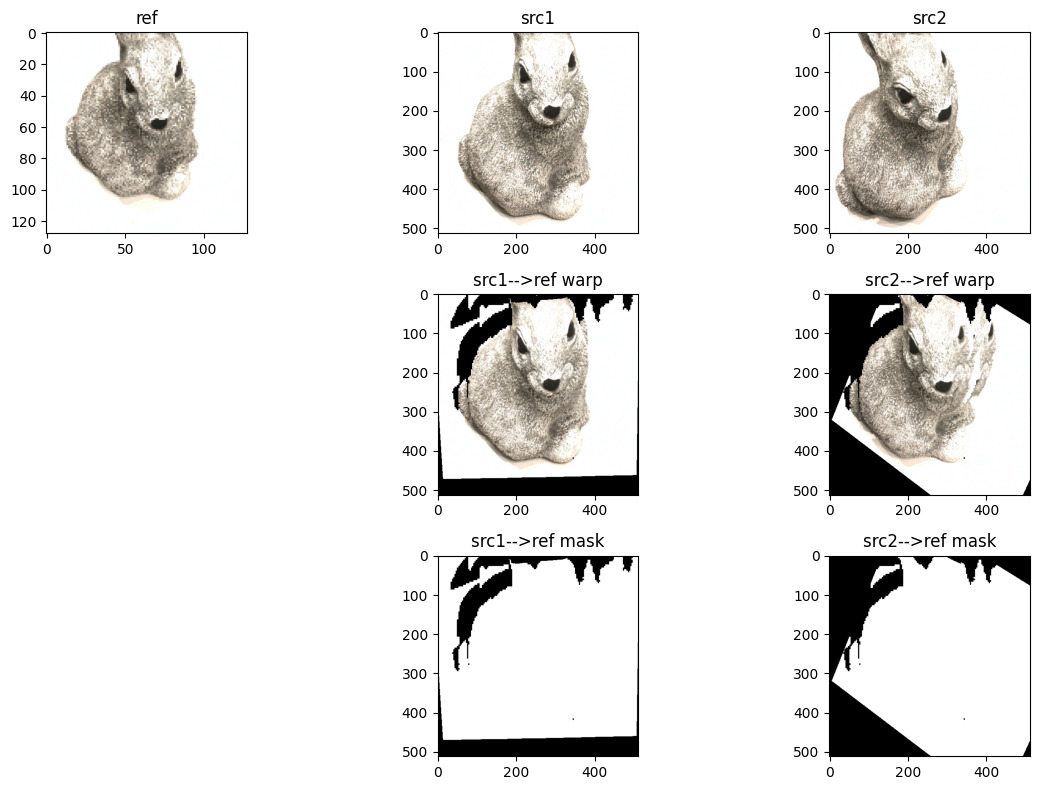

In [4]:
for view in range(1,3):
    view_cam = torch.tensor(item["cams"][view]).unsqueeze(0)  # [B, 2, 4, 4]
    view_image = torch.tensor(item["imgs"][view]).unsqueeze(0)  # [B, C, H, W]
    #view_image = F.interpolate(view_image, scale_factor=0.25, mode='bilinear')
    view_image = view_image.permute(0, 2, 3, 1)
    

    warped_img, mask = inverse_warping(view_image, ref_cam, view_cam, depth)
    print(warped_img.shape,mask.shape)
    warped_images_np.append(warped_img[0].cpu().numpy())
    view_images_np.append(view_image[0].cpu().numpy())
    masks_np.append(mask.repeat(1, 1, 1, 3)[0].cpu().numpy())

ref_image_np = ref_image[0].cpu().numpy()

from matplotlib import pyplot as plt
import cv2
plt.figure(figsize=[12, 8])
plt.subplot(3, 3, 1)
plt.imshow(ref_image_np)
plt.title('ref')
plt.subplot(3, 3, 2)
plt.imshow(view_images_np[0])
plt.title('src1')
plt.subplot(3, 3, 3)
plt.imshow(view_images_np[1])
plt.title('src2')
plt.subplot(3, 3, 5)
plt.imshow(warped_images_np[0] * masks_np[0])
# plt.imshow(warped_images_np[0])
plt.title('src1-->ref warp')
plt.subplot(3, 3, 6)
plt.imshow(warped_images_np[1]* masks_np[1])
# plt.imshow(warped_images_np[1])
plt.title('src2-->ref warp')
plt.subplot(3, 3, 8)
plt.imshow(masks_np[0])
plt.title('src1-->ref mask')
plt.subplot(3, 3, 9)
plt.imshow(masks_np[1])
plt.title('src2-->ref mask')
plt.tight_layout()
plt.show()



In [5]:
import sys
sys.path.append("/root/autodl-tmp/Self-Supervised-MVS/jdacs-ms")

from Losses.unsup_seg_loss import UnSupSegLoss

In [1]:
def build_model(trial,
                lambda_content, upscale_factor,
                in_channel, out_channel, model,):

nf = trial.nf
lr = trial.lr
num_groups2 =trial.num_groups2
num_groups1 = trial.num_groups1

print(f'nf: {nf}, lambda_content: {lambda_content}, \
        upscale_factor:{upscale_factor}, in_channel: {in_channel}, \
        out_channel: {out_channel}, lr: {lr}')

configs = namedtuple('configs', ['nf',
                                        'lambda_content', 
                                        'upscale_factor', 'in_channel', 'out_channel', 'model','lr'])
configs.nf = nf
configs.lambda_content = lambda_content
configs.upscale_factor = upscale_factor
configs.in_channel = in_channel
configs.out_channel = out_channel
configs.model = model
configs.num_groups1 = num_groups1
configs.num_groups2 = num_groups2
configs.lr = lr

return Net(configs)
        

In [8]:
class configs:
    seg_clusters=4

In [12]:
criteria = UnSupSegLoss(configs).cuda()
item = train_dataset[100]
images = torch.tensor(item["imgs"]).unsqueeze(0).cuda()  # [B, C, H, W]

cams = torch.tensor(item["cams"]).unsqueeze(0).cuda()  # [B, 2, 4, 4]
# depth
depth = torch.tensor(item["depth"]).unsqueeze(0).squeeze(-1).cuda()
criteria(images,cams,depth)[1].shape

/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(128, 160)


/tmp/ipykernel_33714/392069440.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(item["imgs"]).unsqueeze(0).cuda()  # [B, C, H, W]
/tmp/ipykernel_33714/392069440.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cams = torch.tensor(item["cams"]).unsqueeze(0).cuda()  # [B, 2, 4, 4]
/tmp/ipykernel_33714/392069440.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  depth = torch.tensor(item["depth"]).unsqueeze(0).squeeze(-1).cuda()
/root/miniconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: 

torch.Size([1, 512, 512, 4])

In [16]:
classes = criteria(images,cams,depth)[1]

/root/miniconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [17]:
# the classes label is classes, use plt to plot


tensor([6.4639e-29, 1.5648e-01, 7.6684e-02, 0.0000e+00], device='cuda:0')